In [7]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import numpy as np

import scipy.stats as st
from time import sleep
from glob import glob

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import ast
import dask.dataframe as dd

tqdm.pandas()
centimeter = 1/2.54


In [2]:
color_palette = {
    'White' : '#ffffb3',
    'Asian' : '#fb8072',
    'M. Eastern' : '#80b1d3',
    'Latinx' : '#fdb462',
    'Indian' : '#b3de69',
    'Black' : '#fccde5',
    'male' : '#bebada',
    'female' : '#8dd3c7'
}

In [4]:
posters_all = pd.read_csv('../../data/movie_posters/All_posters.csv')
posters_all.dropna(inplace = True)
posters_all = posters_all.loc[posters_all['person'] == 'yes']
posters_all['posture'] = posters_all['posture'].apply(lambda x: x.replace('-', ' '))
posters_all['posture'] = posters_all['posture'].apply(lambda x: x.replace(',', ''))
posters_all['body'] = posters_all['body'].apply(lambda x: x.replace('-', ' '))
posters_all['dominant'] = posters_all['dominant'].apply(lambda x: x.replace('.', ''))
posters_all['center'] = posters_all['center'].apply(lambda x: x.replace('.', ''))



In [5]:
def clean_posture(s):
    return_d = {'female' : [], 'male' : [], 'child' : []}
    s = s.split('&')
    s = [x.strip() for x in s]
    
    for x in s:
        x = x.split(' ')
        if x[0] == 'male' or x[0] == 'female':
            return_d[x[0]].append(' '.join(x[1:]))
            
    return return_d

d = {}
for i, row in posters_all.iterrows():
    d[row['image']] = clean_posture(row['posture'])
    
countries = []
years = []
ids = []
genders = []
postures = []

for item in d:
    country = item.split('_')[0]
    year = item.split('_')[1]
    id = item.split('_')[2]
    
    for g in ['female', 'male']:
        for p in d[item][g]:
            genders.append(g)
            postures.append(p)
            countries.append(country)
            years.append(year)
            ids.append(id)


df = pd.DataFrame({'country' : countries, 'year' : years, 'id' : ids, 'gender' : genders, 'posture': postures})

df = df.replace({'seated' : 'sitting'})
df = df.replace({'lying down' : 'reclining'})
df = df.replace({'lying' : 'reclining'})
df = df.replace({'reclined' : 'reclining'})


counts = df[['country', 'gender', 'posture']].value_counts().reset_index().rename(columns={0 : 'count'})
counts = counts.loc[counts['posture'] != '']

def get_percentage(row):
    return row['count'] / counts.loc[(counts['country'] == row['country']) & (counts['gender'] == row['gender'])]['count'].sum() * 100

counts['percentage'] = counts.apply(lambda row: get_percentage(row), axis = 1)

countries = []
diffs = []
postures = []
for country in counts['country'].unique():
    for posture in counts['posture'].unique():
        sliced = counts.loc[(counts['posture'] == posture) & (counts['country'] == country)].sort_values(by = 'gender')
        if len(sliced) == 2:
            diff = sliced.iloc[0]['percentage'] - sliced.iloc[1]['percentage']
            
            diffs.append(diff)
            postures.append(posture)
            countries.append(country)
            
diffs = pd.DataFrame({'country': countries, 'posture' : postures, 'diff' : diffs})
diffs = diffs.sort_values(by = 'diff', ascending=False)
diffs.head(30)

for country in diffs['country'].unique():
    print(country)
    print(diffs.loc[diffs['country'] == country].sort_values(by = 'diff', ascending=False).iloc[0, 1], diffs.loc[diffs['country'] == country].sort_values(by = 'diff', ascending=False).iloc[0, 2])
    print(diffs.loc[diffs['country'] == country].sort_values(by = 'diff', ascending=True).iloc[0, 1], diffs.loc[diffs['country'] == country].sort_values(by = 'diff', ascending=True).iloc[0, 2])
    
countries = []
sitting =[]
reclining = []
standing = []


for country in diffs['country'].unique():
    
    try:
        sitting.append(round(diffs.loc[(diffs['country'] == country) & (diffs['posture'] == 'sitting')]['diff'].values[0], 1))
        reclining.append(round(diffs.loc[(diffs['country'] == country) & (diffs['posture'] == 'reclining')]['diff'].values[0], 1))
        standing.append(round(diffs.loc[(diffs['country'] == country) & (diffs['posture'] == 'standing')]['diff'].values[0], 1))
        countries.append(country)
    except:
        pass
    

posture_df = pd.DataFrame({'country' : countries, 'sitting' : sitting, 'reclining' : reclining, 'standing' : standing})
posture_df = posture_df.sort_values(by = 'standing', ascending=False)


country_order = list(posture_df['country'].values)
print(country_order)

posture_df.head(15)


turkish
sitting 3.639052882069647
standing -7.74232858030301
english
sitting 3.2558460847639132
standing -6.447722013056541
japanese
sitting 3.249377414393747
standing -5.442900076234643
portugeuse
reclining 3.1036588283709934
standing -1.6286619388057773
spanish
reclining 2.5477981541243615
standing -4.996032066506785
french
reclining 2.3878695103642174
standing -6.16846765674623
indian
leaning 2.077792201951992
standing -3.4805707874693255
chinese
sitting 2.0070421997210026
standing -2.1569538936418695
german
reclining 1.7505026311288545
standing -2.345795105090609
arabic
sitting 1.5235330472464668
standing -2.0490116756514354
persian
neutral 1.4765206844728036
standing -3.744034592770319
['portugeuse', 'arabic', 'chinese', 'german', 'indian', 'persian', 'spanish', 'japanese', 'french', 'english', 'turkish']


,country,sitting,reclining,standing
3,portugeuse,-1.4,3.1,-1.6
9,arabic,1.5,0.9,-2.0
7,chinese,2.0,1.7,-2.2
8,german,-0.2,1.8,-2.3
6,indian,-0.8,1.1,-3.5
10,persian,1.3,1.3,-3.7
4,spanish,1.6,2.5,-5.0
2,japanese,3.2,2.9,-5.4
5,french,1.6,2.4,-6.2
1,english,3.3,2.9,-6.4


In [6]:
df['year'] = df['year'].astype(int)

In [10]:


def plot_postures(df):
    
    fig, ax = plt.subplots(1, 1, figsize=(6.6*centimeter, 8.9*centimeter))
    
    ax.set_xlim(-9.5, 5)
    ax.set_ylim(0.5, len(df)+0.5)
    ax.vlines(x = 0, ymin=-1, ymax=len(df)+1, color = 'black', linestyle = '-', alpha = 0.5, linewidth = 0.25)
    
    # ax.fill_between([0, 10], 0.5, 12, color = 'lightgrey', alpha = 0.25)
    
    sitting_image = plt.imread('../assets/sitting.png')
    reclining_image = plt.imread('../assets/reclining.png')
    standing_image = plt.imread('../assets/standing.png')
    
    df = df.sort_values(by = 'standing', ascending=False)
    
    for i, row in df.iterrows():
        im = OffsetImage(sitting_image, zoom=0.025)
        ab = AnnotationBbox(im, (row['sitting'], len(df)-i), frameon=False)
        ax.add_artist(ab)
        
        im = OffsetImage(reclining_image, zoom=0.025)
        ab = AnnotationBbox(im, (row['reclining'], len(df)-i), frameon=False)
        ax.add_artist(ab)
        
        im = OffsetImage(standing_image, zoom=0.025)
        ab = AnnotationBbox(im, (row['standing'], len(df)-i), frameon=False)
        ax.add_artist(ab)
        
        country = row['country']
        
        if country == 'indian':
            ax.text(s = 'Hindi\nTamil', x = -10, y = len(df)-i, fontsize = 8, ha = 'right', va = 'center')
        elif country == 'chinese':
            ax.text(s = 'Mandarin\nCantonese', x = -10, y = len(df)-i, fontsize = 8, ha = 'right', va = 'center')
        else:
            ax.text(s = country.capitalize(), x = -10, y = len(df)-i, fontsize = 8, ha = 'right', va = 'center')

        
    

    
    
    ax.set_xticks([ -5,  0, 5])
    ax.set_xticklabels([ '5',  '0', '5'], fontsize = 8)
    ax.set_xlabel('Difference in posture portrayal (%)', fontsize= 8)
    
    ax.set_yticklabels([])
    
    ax.text(s = 'More male\nportrayal', x = -8, y = 12, fontsize = 7, ha = 'left')
    ax.text(s = 'More female\nportrayal', x = 5, y = 12, fontsize = 7, ha = 'right')
    # ax.tick_params(left = False)
    ax.set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
    
    
    sns.despine(left = True)
    fig.show()
    # fig.savefig('../figures/posture_differences_allposters.pdf', bbox_inches='tight', dpi = 300)
        

/var/folders/q2/jh49nbrj73x3lvwvlz9642xm0000gp/T/ipykernel_35216/2052971356.py:57: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


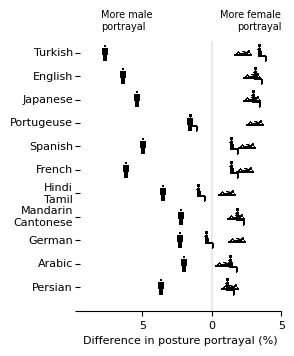

In [11]:
plot_postures(posture_df)

In [12]:
df = pd.read_csv('../../data/movie_posters/body_composition_allposters.csv')
df['body'].value_counts()

df = df.loc[df['body'].isin(['full-body', 'face', 'torso'])]

df = df.replace({'full-body' : '1_Full-body', 'face' : '3_Face', 'torso' : '2_Torso'})

In [13]:
df[['country', 'gender', 'body']].value_counts()

country     gender  body       
japanese    male    1_Full-body    7795
english     male    1_Full-body    7433
chinese     male    1_Full-body    7291
japanese    female  1_Full-body    6154
chinese     male    2_Torso        6025
                                   ... 
portugeuse  female  3_Face          293
arabic      female  3_Face          291
persian     male    3_Face          288
turkish     female  3_Face          264
persian     female  3_Face          194
Name: count, Length: 66, dtype: int64

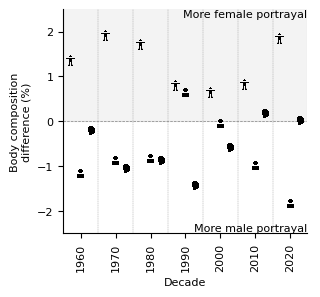

In [14]:
def meanCI(a, conf=0.95):
    mean, sem, m = np.mean(a), st.sem(a), st.t.ppf((1+conf)/2., len(a)-1)
    return mean, sem*1.986

def get_offset(k):
    return (k - 2) * 5

def plot_body_percentages_temporal_bars(df):
    
    fig, ax = plt.subplots(1, 1, figsize=(16*centimeter/2, 3.7*2*centimeter))
    
    face_image = plt.imread('../assets/face.png')
    body_image = plt.imread('../assets/body.png')
    torso_image = plt.imread('../assets/torso.png')
    
    df['decade'] = df['year'].apply(lambda x: x//10 * 10)
    df = df.loc[df['decade'] >= 1960]
    
    
    ax.set_xlim(1955, 2025)
    ax.set_ylim(-2.5, 2.5)

        
    for decade in df['decade'].unique():
        full_body_percentages = {}
        face_percentages = {}
        torso_percentages = {}
        
        for gender in df['gender'].unique():
            sliced = df.loc[(df['decade'] == decade) & (df['gender'] == gender)]
            full_body_percentages[gender] = sliced['body'].value_counts(normalize = True).loc['1_Full-body'] * 100
            try:
                face_percentages[gender] = sliced['body'].value_counts(normalize = True).loc['3_Face'] * 100
            except:
                face_percentages[gender] = 0
            torso_percentages[gender] = sliced['body'].value_counts(normalize = True).loc['2_Torso'] * 100
        
        im = OffsetImage(body_image, zoom=0.015)
        ab = AnnotationBbox(im, (decade - 3, full_body_percentages['female'] - full_body_percentages['male']), frameon=False)
        ax.add_artist(ab)
        
        im = OffsetImage(face_image, zoom=0.0125)
        ab = AnnotationBbox(im, (decade + 3, face_percentages['female'] - face_percentages['male']), frameon=False)
        ax.add_artist(ab)
        
        im = OffsetImage(torso_image, zoom=0.0125)
        ab = AnnotationBbox(im, (decade, torso_percentages['female'] - torso_percentages['male']), frameon=False)
        ax.add_artist(ab)

    ax.set_xlabel('Decade', fontsize = 8)
    
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.hlines(y = 0, xmin = 1955, xmax = 2025, color = 'grey', linestyle = '--', linewidth = 0.5)
    ax.fill_between([1955, 2025], 0, 55, color = 'lightgrey', alpha = 0.25)
    ax.set_ylabel('Body composition\ndifference (%)', fontsize = 8)
    
    ax.text(s = 'More female portrayal', x = 2025, y = 2.5, fontsize = 8, ha = 'right', va = 'top')
    ax.text(s = 'More male portrayal', x = 2025, y = -2.5, fontsize = 8, ha = 'right', va = 'bottom')
    
    for year in [1965, 1975, 1985, 1995, 2005, 2015]:
        ax.vlines(x = year, ymin = -7, ymax = 7, color = 'grey', linestyle = '--', linewidth = 0.25)
    ax.set_xticks([1960, 1970, 1980, 1990, 2000, 2010, 2020])
    ax.set_xticklabels(['1960', '1970', '1980', '1990', '2000', '2010', '2020'], fontsize = 8, rotation = 90)
        
    sns.despine()
    
    plt.subplots_adjust(hspace=0.1)
    # fig.savefig('../figures/body_composition_temporal_combined_allposters.pdf', bbox_inches='tight', dpi = 300)
    
plot_body_percentages_temporal_bars(df)

In [15]:
path = '../../data/movie_posters/Hollywood_genres/'

poster_genres = pd.DataFrame()

for item in os.listdir(path):
    temp = pd.read_csv(path + item)
    poster_genres = pd.concat([poster_genres, temp])
    
poster_genres['id'] = poster_genres['id'].apply(lambda x: str(int(x)) + '.jpg')
poster_genres = pd.merge(poster_genres, df, on = 'id')
top_10_genres = poster_genres['genre'].value_counts().reset_index()['genre'][:7].to_list()
poster_genres['is_top'] = poster_genres['genre'].apply(lambda x: True if x in top_10_genres else False)
poster_genres.head()

,id,genre,country,year,gender,body,decade,is_top
0,128437.jpg,Western,english,1964,male,2_Torso,1960,False
1,128437.jpg,Western,english,1964,male,2_Torso,1960,False
2,212713.jpg,Comedy,english,1964,female,3_Face,1960,True
3,212713.jpg,Comedy,english,1964,male,3_Face,1960,True
4,212713.jpg,Comedy,english,1964,male,2_Torso,1960,True


In [16]:
top = poster_genres.loc[poster_genres.is_top == True]

d = {}
for genre in top.genre.unique():
    sliced = top.loc[top.genre == genre]
    d[genre] = []
    
    for item in ['1_Full-body', '2_Torso', '3_Face']:
        diff = abs(sliced.loc[sliced['gender'] == 'male']['body'].value_counts(normalize = True).loc[item] * 100 \
            - sliced.loc[sliced['gender'] == 'female']['body'].value_counts(normalize = True).loc[item] * 100)
        d[genre].append(diff)
        
    d[genre] = np.mean(d[genre])
    

d = sorted(d.items(), key=lambda x: x[1], reverse=True)
order = [item[0] for item in d]
order
        
    

['Action', 'Romance', 'Comedy', 'Adventure', 'Crime', 'Drama', 'Thriller']

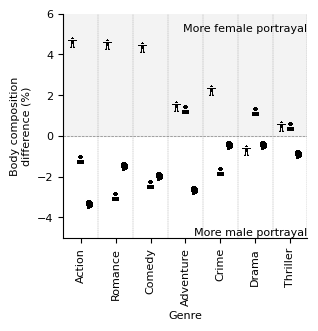

In [17]:
def plot_body_percentages_genre(df):
    
    fig, ax = plt.subplots(1, 1, figsize=(16*centimeter/2, 3.7*2*centimeter))
    
    face_image = plt.imread('../assets/face.png')
    body_image = plt.imread('../assets/body.png')
    torso_image = plt.imread('../assets/torso.png')
    
    df = df.loc[df['is_top'] == True]
    
    ax.set_xlim(-0.5, 6.5)
    ax.set_ylim(-5, 6)

        
    for i, genre in enumerate(order):
        full_body_percentages = {}
        face_percentages = {}
        torso_percentages = {}
        
        for gender in df['gender'].unique():
            sliced = df.loc[(df['genre'] == genre) & (df['gender'] == gender)]
            full_body_percentages[gender] = sliced['body'].value_counts(normalize = True).loc['1_Full-body'] * 100
            try:
                face_percentages[gender] = sliced['body'].value_counts(normalize = True).loc['3_Face'] * 100
            except:
                face_percentages[gender] = 0
            torso_percentages[gender] = sliced['body'].value_counts(normalize = True).loc['2_Torso'] * 100
        
        im = OffsetImage(body_image, zoom=0.015)
        ab = AnnotationBbox(im, (i - 0.25, full_body_percentages['female'] - full_body_percentages['male']), frameon=False)
        ax.add_artist(ab)
        
        im = OffsetImage(face_image, zoom=0.0125)
        ab = AnnotationBbox(im, (i + 0.25, face_percentages['female'] - face_percentages['male']), frameon=False)
        ax.add_artist(ab)
        
        im = OffsetImage(torso_image, zoom=0.0125)
        ab = AnnotationBbox(im, (i, torso_percentages['female'] - torso_percentages['male']), frameon=False)
        ax.add_artist(ab)

    ax.set_xlabel('Genre', fontsize = 8)

    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.hlines(y = 0, xmin = -0.5, xmax = 9.5, color = 'grey', linestyle = '--', linewidth = 0.5)
    ax.fill_between([-0.5, 9.5], 0, 10, color = 'lightgrey', alpha = 0.25)
    ax.set_ylabel('Body composition\ndifference (%)', fontsize = 8)
    
    ax.text(s = 'More female portrayal', x = 6.5, y = 5.5, fontsize = 8, ha = 'right', va = 'top')
    ax.text(s = 'More male portrayal', x = 6.5, y = -5, fontsize = 8, ha = 'right', va = 'bottom')
    
    for year in [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]:
        ax.vlines(x = year, ymin = -7, ymax = 7, color = 'grey', linestyle = '--', linewidth = 0.25)
        
    ax.set_xticks([0, 1, 2, 3, 4, 5, 6])
    ax.set_xticklabels(order, rotation = 90, fontsize = 8)
        
    sns.despine()
    
    plt.subplots_adjust(hspace=0.1)
    # fig.savefig('../figures/body_composition_genre_allposters.pdf', bbox_inches='tight', dpi = 300)
    
plot_body_percentages_genre(poster_genres)

In [18]:
posters_all = posters_all.loc[posters_all['person'] == 'yes']

def get_cluster(x):
    if type(x) != str:
        return ['Error']
    
def get_cluster(x):
    if type(x) != str:
        return ['Error']
    
    if pd.isnull(x):
        return ['Empty']
    if 'not applicable' in x or 'N/A' in x:
        return ['Not applicable']
    clusters = []
    if 'no' in x and ('found' in x or 'portrayed' in x or 'included' in x or 'depicted' in x or 'present' in x or 'shown' in x):
        return ['None found']
    
    for item in ['neutral']:
        if item in x:
            clusters.append('neutral')
    for item in ['sensual', 'attractive', 'sensually']:
        if item in x:
            clusters.append('sensual')
    for item in ['submissive', 'vunerably', 'vulnerably', 'submissively']:
        if item in x:
            clusters.append('submissive')
    for item in ['dominant', 'powerful', 'dominantly', 'powerfully']:
        if item in x:
            clusters.append('dominant')
    for item in ['casual', 'casually']:
        if item in x:
            clusters.append('casual')
    for item in ['serious', 'seriously']:
        if item in x:
            clusters.append('serious')
    for item in ['confident', 'confidently']:
        if item in x:
            clusters.append('confident')
    for item in ['happy', 'happily', 'cheerful', 'cheerfully','joyous', 'joyfully', 'enthusiastic', 'enthusiastically']:
        if item in x:
            clusters.append('happy')
    for item in ['sad', 'sadly']:
        if item in x:
            clusters.append('sad')
    for item in ['angry', 'angrily']:
        if item in x:
            clusters.append('angry')
    for item in ['playfully', 'playful']:
        if item in x:
            clusters.append('playful')
    for item in ['fearful', 'fearfully']:
        if item in x:
            clusters.append('fearful')
    for item in ['disgusted', 'disgustingly']:
        if item in x:
            clusters.append('disgusted')
    for item in ['surprised', 'surprisingly']:
        if item in x:
            clusters.append('surprised')
    for item in ['positively', 'positive']:
        if item in x:
            clusters.append('positive')
    for item in ['negatively', 'negative']:
        if item in x:
            clusters.append('negative')
    for item in ['engaged in']:
        if item in x:
            clusters.append('engaged in activity')   
    
    clusters = list(set(clusters))
    
    if len(clusters) == 0:
        clusters.append('Error')
    
    return clusters
                    
posters_all['cluster_female'] = posters_all['female'].apply(lambda x: get_cluster(x))
posters_all['cluster_male'] = posters_all['male'].apply(lambda x: get_cluster(x))

female_clusters = posters_all.loc[posters_all['cluster_female'].isin([['None found'], ['Error'], ['Not applicable']]) == False]
male_clusters = posters_all.loc[posters_all['cluster_male'].isin([['None found'], ['Error'], ['Not applicable']]) == False]

# cluster_counts = pd.DataFrame(columns = ['gender', 'cluster'])

genders = []
clusters = []

for item in female_clusters.cluster_female.values:
    for cluster in item:
        genders.append('female')
        clusters.append(cluster)
        
for item in male_clusters.cluster_male.values:
    for cluster in item:
        genders.append('male')
        clusters.append(cluster)
        
cluster_counts = pd.DataFrame({'gender' : genders, 'cluster' : clusters})

pivot = cluster_counts.groupby('gender').value_counts(normalize = True).reset_index()
pivot['proportion'] = pivot['proportion'] * 100

pivot = pivot.pivot_table(index = 'cluster', columns = 'gender', values = 'proportion').fillna(0)
pivot['diff'] = pivot['female'] - pivot['male']
pivot_clean = pivot.loc[(pivot['female'] > 1) | (pivot['male'] > 1)].sort_values(by = 'diff', ascending = False).reset_index()
pivot_clean


gender,cluster,female,male,diff
0,confident,23.363240,17.969244,5.393995
1,sensual,4.808438,0.069800,4.738638
2,playful,8.256547,4.183662,4.072885
3,positive,9.818138,6.299487,3.518650
4,happy,7.538797,5.520777,2.018021
5,submissive,1.408826,0.985931,0.422896
6,engaged in activity,2.723084,2.318683,0.404402
7,surprised,1.229389,1.256407,-0.027019
8,casual,8.998545,11.545425,-2.546880
9,neutral,24.158584,26.884066,-2.725482


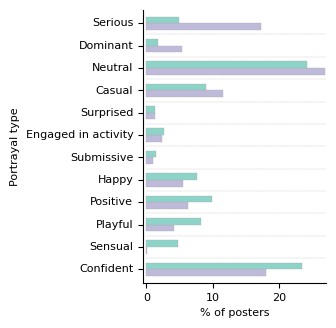

In [19]:
def plot_clusters(df, ax):
    ax.set_xlim(-0.5, 27)
    ax.set_ylim(-0.6, 11.6)
    for i, row in df.iterrows():
        ax.barh(y = i - 0.15, width = row['male'], color = color_palette['male'], height = 0.3, edgecolor = '#adadad', linewidth = 0.25)
        ax.barh(y = i + 0.15, width = row['female'], color = color_palette['female'], height = 0.3, edgecolor = '#adadad', linewidth = 0.25)
        
    
        
    for i in [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5]:
        ax.hlines(y = i, xmin = 0, xmax= 27, color = 'black', linestyle = '--', zorder = -100, alpha = 0.5, linewidth = 0.15)
    ax.set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
    ax.set_yticklabels([item.capitalize() for item in df['cluster'].values], rotation = 0, fontsize = 8, va = 'center')
    ax.set_xlabel('% of posters', fontsize = 8)
    ax.set_ylabel('Portrayal type', fontsize = 8)
    

fig, axs = plt.subplots(1, 1, figsize=(6*centimeter, 9*centimeter))
plot_clusters(pivot_clean, axs)
axs.tick_params(axis='both', which='major', labelsize=8)
sns.despine()

# fig.savefig('../figures/cluster_percentages_posters.pdf', dpi = 300, bbox_inches = 'tight')